## Project: Computer simulation of a roadblock model of translational control
## Author: Gabin ROUSSEAU

Practice formatting a TASEP simulation to the scipy solve_ivp ODE solver to then refine the model to fit Ssd1 roadblocking in translation initiation.

In Bartlomiej Waclaw's Wolfram demonstration from 2018, TASEP (Totally Asymmetric Simple Exclusion Process) is described as:
A lattice model in which particles hop into a one-dimensional lattice from one end with a r<sub>in</sub>, hop along lattice units with rate 1 and exit from the other end with a rate r<sub>out</sub>.
Both r<sub>in</sub> and r<sub>out</sub> are equal to or inferior to 1, and only one particle can occupy a site (the next site needs to be empty to be accessed.)
The model shows phase transitions between low-density = limited by r<sub>in</sub>, high-density = limited by r<sub>out</sub> and maximum-current.

In addition to initiation and termination rates, the lattice is also defined by its length L (recommend from 3 to 100). The demonstration also gives control of the simulation speed = how many iterations pass before the interface is actualised.

Down the line, I already know I will need to take into account Ssd1. If Ssd1 can be modeled by a roadblock attaching itself to a specific site, which means the model would need a way to qualify sites for roadblock binding.


 	
https://doi.org/10.48550/arXiv.2308.00847 TASEPy: a Python-based package to iteratively solve the inhomogeneous exclusion process (Juraj's)
See section 2:
can model 43S as a particle of footprint 50 on a lattice of 250 units (base pairs)?

### Build a first TASEP-emulating function that uses the exclusion principle described in:
#### Core variables involved:

**t = number of iterations**

**a = first site loading probability**

**b = final site unloading probability**

**L = length of the lattice**

**l = length of a particle passed in the lattice**

**State of an individual site** of index i = **Si** (i=1, ..., L)
With S = {1 if occupied, 0 if empty}

_**Note:** The state of occupation refers to a particle's tracked site exclusively, and the exclusion principle will take that into account to allow passage from one site to another. If all sites blocked by a particle were considered "occupied", it would cause problems when counting the particles on the lattice, especially if the model will end up having to qualify particle types._

**pi = probability of hopping from site i to site i+1** (for i=1,...,L-1)


Site states will be grouped in the **configuration array C = [S1,..., SL]**

Hopping probabilities will be grouped in the **progression arrary P = [p1,...,pL-1]**


---
_roadblock_ini - v0.1_

In the first model, probabilities will be fixed and the only user input will be L and l.

In [1]:
###############################################################################
#
#       roadblock_ini (rini) v0.1
#                               January 2024
#
#       Author: Gabin Rousseau
#
###############################################################################

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd
import csv

In [2]:
def rini(t, L, l):
    '''
    roadblock_ini v0.1 
    (rini for short)
    
    Takes 3 arguments: t, L, l
    t: number of iterations to run the TASEP model
    L: lattice length
    l: particle length
    
    This is the first version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation in S. cerevisiae.
    
    Loading, unloading, and hopping rates are pre-determined and constant.
    These rates work as probabilities for a change in a site to occur. 
    The function will check at each iteration which sites are occupied by a tracked particle unit and randomly assign the order in which the fate of the respective particles present will be decided, as well as loading or unloading opportunities.
    The model aims to fit the inhomogeneous TASEP formulaism proposed by MacDonald, Gibbs and Pipkin in 1968 (https://doi.org/10.1002/bip.1968.360060102).
    
    Note: there is a chance that a single particle will be moved twice in a single iteration. This can happen when a particle enters the last site before the unloading is considered, in which case the particle would be unloaded in the same step.
    The same cannot happen after loading as the model snapshots the particles present at the beginning of the iteration: a newly loaded particle wouldn't be considered for movement in the same iteration.
    This can be solved by changing the condition behind the decision for unloading for unloading to not systematically being checked for without the presence of a relevant particle at the beginning of the iteration.
    -->fixed
    -->nevermind, the problem still happens at a lower rate
    -->fixed, that was because the model did one more loop than the requested timer
    
    
    Goal:make the model return a csv dataframe which can contain different types of relevant information over time (e.g., number of particles passed through the entirety of the lattice).
    -->done, pandas dataframe containing iteration (in addition to t=0), total passed particles, config, individual states
    -->removed the configuration from the dataframe, appending 'C' every iteration ends up filling the table with the final configuration only. Confusing. (all individual site states are still in though, and they seem to be working)
    '''
    
    #set initial variables
    a = 0.8
    b = 0.8
    S_start=0
    p_values=0.95
    C=[]
    P=[]
    for i in range(L):
        C.append(S_start)
        if i < L-1:
            P.append(p_values) 
    passed=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0]}
    loc1=0
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    
    #exclusion rule variables
    acondition=C[0:l]
    
    
    #launch model
    for iteration in range(t):
        #for this iteration, make a randomly ordered list of site indicies to check: S1 for loading, sites occupied by a tracked particle unit for scanning, SL for unloading
        iterparticle=['load',L-1]
        loc2=-1
        for S in C[0:L-1]:
            loc2+=1
            if S==1:
                iterparticle.append(loc2)       
        random.shuffle(iterparticle)
        
        #go through each step of the iteration in the random order
        
        for step in iterparticle:
            if step == 'load':
                #LOADING
                acontext=C[0:l]
                if acontext==acondition:
                    a_roll=random.uniform(0,1)
                    if a_roll<=a:    
                        C[0]+=1
                    
            elif step == L-1:
                #UNLOADING
                if C[L-1]==1:
                    b_roll=random.uniform(0,1)
                    if b_roll<=b:
                        C[L-1]-=1
                        passed+=1
                                          
            else:
                #SCANNING
                if step <= L-l-1:
                    if C[step+l]==0:
                        p_roll=random.uniform(0,1)
                        if p_roll<= P[step]:
                            C[step]-=1
                            C[step+1]+=1
                                   
                else: #should only affect particles that can't be blocked by another of the same type downstream
                    p_roll=random.uniform(0,1)
                    if p_roll<= P[step]:
                        C[step]-=1
                        C[step+1]+=1
        
        #update dataset
        rini_data.setdefault('time', []).append(iteration+1)
        rini_data.setdefault('passed_total', []).append(passed)
        loc3=0
        for S in C:
            loc3+=1
            rini_data.setdefault(f'S{loc3}', []).append(S)
            
    return pd.DataFrame(data=rini_data)

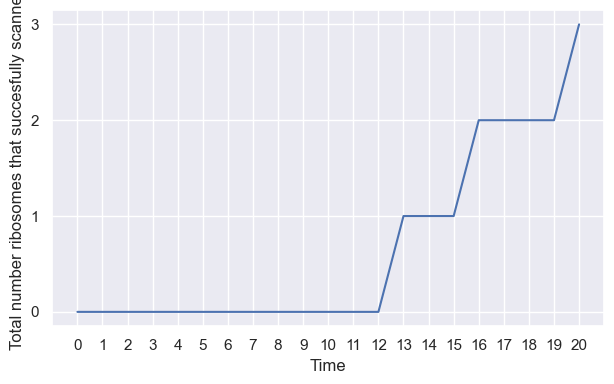

In [6]:
#get a first glance at the model by plotting passed vs. time...
model_test=rini(20, 10, 3)

plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='passed_total', data=model_test)

plt.xlabel('Time')
plt.ylabel('Total number ribosomes that succesfully scanned')
plt.xticks(np.arange(0, max(model_test['time'])+1, step=1))
plt.yticks(np.arange(0, max(model_test['passed_total'])+1, step=1))
plt.tight_layout()
plt.show();

In [16]:
#...and downloading the csv file for t=20, L=10, l=3
#model_test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-1_output/table.csv')

In [14]:
rini(20, 10, 3)

,time,passed_total,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0
2,2,0,0,1,0,0,0,0,0,0,0,0
3,3,0,0,0,1,0,0,0,0,0,0,0
4,4,0,0,0,0,1,0,0,0,0,0,0
5,5,0,1,0,0,0,1,0,0,0,0,0
6,6,0,0,1,0,0,0,1,0,0,0,0
7,7,0,0,0,1,0,0,0,1,0,0,0
8,8,0,0,0,0,1,0,0,0,1,0,0
9,9,0,0,0,0,0,1,0,0,0,1,0
